In [258]:
import numpy as np
import pickle
import matplotlib.pyplot as plt



In [259]:

 
def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)
 
 
def load_batch(filename):
    """ Copied from the dataset website """
    with open('Datasets/' + filename, 'rb') as fo:
        dataset_dict = pickle.load(fo, encoding='bytes')
 
    return dataset_dict
 
 # modified to include w1, b1, w2, b2
def compute_grads_num(X, Y, W1, b1, W2, b2, lamda, h):
    K = W1.shape[0]
    no = W2.shape[0]

    grad_W1 = np.zeros(W1.shape)
    grad_b1 = np.zeros((K, 1))

    c = compute_cost(X, Y, W1, b1, W2, b2, lamda)

    for i in range(len(b1)):
        b_try = np.array(b1)
        b_try[i] += h
        c2 = compute_cost(X, Y, W1, b_try, W2, b2, lamda)
        grad_b1[i] = (c2 - c) / h

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W_try = np.array(W1)
            W_try[i, j] += h
            c2 = compute_cost(X, Y, W_try, b1, W2, b2, lamda)
            grad_W1[i, j] = (c2 - c) / h

    return grad_W1, grad_b1

 
 
def compute_grads_num_slow(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    # d = X.shape[0]
 
    grad_w = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))
 
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = compute_cost(X, Y, W, b_try, lamda)
 
        b_try = np.array(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, lamda)
 
        grad_b[i] = (c2 - c1) / (2 * h)
 
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w_try = np.array(W)
            w_try[i, j] -= h
            c1 = compute_cost(X, Y, w_try, b, lamda)
 
            w_try = np.array(W)
            w_try[i, j] += h
            c2 = compute_cost(X, Y, w_try, b, lamda)
 
            grad_w[i, j] = (c2 - c1) / (2 * h)
 
    return [grad_w, grad_b]
 
 
def montage(W):
    """ Display the image for each label in W """
    fig, ax = plt.subplots(2, 5)
    for i in range(2):
        for j in range(5):
            im = W[i * 5 + j, :].reshape(32, 32, 3, order='F')
            sim = (im - np.min(im[:])) / (np.max(im[:]) - np.min(im[:]))
            sim = sim.transpose(1, 0, 2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].set_title("y=" + str(5 * i + j))
            ax[i][j].axis('off')
    plt.show()
 
 
def save_as_mat(data, name="model"):
    """ Used to transfer a python model to matlab """
    import scipy.io as sio
    sio.savemat(f'{name}.mat', {"name": "b"})


In [260]:
#assignment 2.1 similar code as in assignment 1.1 and 1.2

def load(filename):
    data = load_batch(filename)
    
    X = data[b'data'].astype(np.float32).reshape(-1, 3072).T / 255
    y = np.array(data[b'labels']).astype(np.int32)
    
    Y = np.zeros((10, y.shape[0]), dtype=np.float32)
    for i, label in enumerate(y):
        Y[label, i] = 1
    
    return X, Y, y + 1

train_X, train_Y, train_y = load('data_batch_1')

val_X, val_Y, val_y = load('data_batch_2')

test_X, test_Y, test_y = load('test_batch')



def normalize_data(trainX, X):
    mean_X = np.mean(trainX, axis=1, keepdims=True)
    std_X = np.std(trainX, axis=1, keepdims=True)
    
    normalized_X = (X - mean_X) / std_X
    
    return normalized_X

train_X = normalize_data(train_X, train_X)
val_X = normalize_data(train_X, val_X)
test_X = normalize_data(train_X, test_X)




# Initialize network parameters
def initialize_network(d, m, K):
    W1 = np.random.randn(m, d) / np.sqrt(d)
    b1 = np.zeros((m, 1))
    W2 = np.random.randn(K, m) / np.sqrt(m)
    b2 = np.zeros((K, 1))
    return W1, b1, W2, b2

d = train_X.shape[0]  # Number of input features
m = 50                # Number of nodes in the hidden layer
K = 10                # Number of output classes

W1, b1, W2, b2 = initialize_network(d, m, K)


In [261]:
#Assignment 2.2

# Forward pass function
def forward_pass(X, W1, b1, W2, b2):
    # Input to hidden layer
    A1 = np.dot(W1, X) + b1
    H = np.maximum(A1, 0)

    # Hidden layer to output
    A2 = np.dot(W2, H) + b2
    P = softmax(A2)

    return P, H






# Gradient computation function
def compute_gradients(X, Y, H, P, W1, b1, W2, b2, lamda):
    N = X.shape[1]
    G = -(Y - P)
    grad_W2 = np.dot(G, H.T) / N + lamda * W2
    grad_b2 = np.sum(G, axis=1).reshape(-1, 1) / N

    H_grad = np.dot(W2.T, G)  
    H_grad[H <= 0] = 0

    grad_W1 = np.dot(H_grad, X.T) / N + lamda * W1
    grad_b1 = np.sum(H_grad, axis=1).reshape(-1, 1) / N

    return grad_W1, grad_b1, grad_W2, grad_b2




#def compute_grads_num(X, Y, W1, b1, W2, b2, lamda, h):
#    P, H = forward_pass(X, W1, b1, W2, b2)
#    grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X, Y, H, P, W1, b1, W2, b2, lamda)
#
#    return grad_W1, grad_b1, grad_W2, grad_b2


def compute_grads_num(X, Y, W1, b1, W2, b2, lamda, h):
    K1 = W1.shape[0]
    K2 = W2.shape[0]

    grad_W1 = np.zeros(W1.shape)
    grad_b1 = np.zeros((K1, 1))
    grad_W2 = np.zeros(W2.shape)
    grad_b2 = np.zeros((K2, 1))

    for i in range(len(b1)):
        b_try = np.copy(b1)
        b_try[i] += h
        c1 = compute_cost(X, Y, W1, b_try, W2, b2, lamda)

        b_try[i] -= 2 * h
        c2 = compute_cost(X, Y, W1, b_try, W2, b2, lamda)

        grad_b1[i] = (c1 - c2) / (2 * h)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W_try = np.copy(W1)
            W_try[i, j] += h
            c1 = compute_cost(X, Y, W_try, b1, W2, b2, lamda)

            W_try[i, j] -= 2 * h
            c2 = compute_cost(X, Y, W_try, b1, W2, b2, lamda)

            grad_W1[i, j] = (c1 - c2) / (2 * h)

    for i in range(len(b2)):
        b_try = np.copy(b2)
        b_try[i] += h
        c1 = compute_cost(X, Y, W1, b1, W2, b_try, lamda)

        b_try[i] -= 2 * h
        c2 = compute_cost(X, Y, W1, b1, W2, b_try, lamda)

        grad_b2[i] = (c1 - c2) / (2 * h)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W_try = np.copy(W2)
            W_try[i, j] += h
            c1 = compute_cost(X, Y, W1, b1, W_try, b2, lamda)

            W_try[i, j] -= 2 * h
            c2 = compute_cost(X, Y, W1, b1, W_try, b2, lamda)

            grad_W2[i, j] = (c1 - c2) / (2 * h)

    return grad_W1, grad_b1, grad_W2, grad_b2





def test_gradients():
    np.random.seed(42)
    N = 2
    d = 3
    K = 10
    m = 20
    
    X = np.random.rand(d, N)
    Y = np.zeros((K, N))
    for i in range(N):
        Y[np.random.randint(0, K), i] = 1

    W1 = np.random.randn(m, d)
    b1 = np.random.randn(m, 1)
    W2 = np.random.randn(K, m)
    b2 = np.random.randn(K, 1)
    
    lamda = 0.01
    h = 1e-6
    
    # Compute gradients analytically
    P, H = forward_pass(X, W1, b1, W2, b2)
    grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X, Y, H, P, W1, b1, W2, b2, lamda)
    
    # Compute gradients numerically
    num_grad_W1, num_grad_b1, num_grad_W2, num_grad_b2 = compute_grads_num(X, Y, W1, b1, W2, b2, lamda, h)

    print("Relative error for W1:", np.linalg.norm(grad_W1 - num_grad_W1) / max(1e-6, np.linalg.norm(grad_W1) + np.linalg.norm(num_grad_W1)))
    print("Relative error for b1:", np.linalg.norm(grad_b1 - num_grad_b1) / max(1e-6, np.linalg.norm(grad_b1) + np.linalg.norm(num_grad_b1)))
    print("Relative error for W2:", np.linalg.norm(grad_W2 - num_grad_W2) / max(1e-6, np.linalg.norm(grad_W2) + np.linalg.norm(num_grad_W2)))
    print("Relative error for b2:", np.linalg.norm(grad_b2 - num_grad_b2) / max(1e-6, np.linalg.norm(grad_b2) + np.linalg.norm(num_grad_b2)))

test_gradients()


def compute_cost(X, Y, W1, b1, W2, b2, lamda):
    N = X.shape[1]
    P, _ = forward_pass(X, W1, b1, W2, b2)
    cross_entropy_loss = -np.sum(Y * np.log(P)) / N

    regularization_term = 0.5 * lamda * (np.sum(W1 ** 2) + np.sum(W2 ** 2))

    return cross_entropy_loss + regularization_term

def train_network(X, Y, W1, b1, W2, b2, lamda, n_epochs, n_batch, eta):
    N = X.shape[1]

    for epoch in range(n_epochs):
        for j in range(0, N, n_batch):
            X_batch = X[:, j:j + n_batch]
            Y_batch = Y[:, j:j + n_batch]

            grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X_batch, Y_batch, W1, b1, W2, b2, lamda)

            W1 -= eta * grad_W1
            b1 -= eta * grad_b1
            W2 -= eta * grad_W2
            b2 -= eta * grad_b2

        # Compute the cost for the current epoch
        cost = compute_cost(X, Y, W1, b1, W2, b2, lamda)
        print(f"Epoch {epoch + 1}, cost: {cost}")


def sanity_check():
    np.random.seed(123)
    N = 100
    n_epochs = 200
    n_batch = 10
    eta = 0.01
    lamda = 0
    d = 3
    K = 10
    m = 20

    X_small = train_X[:, :N]
    Y_small = train_Y[:, :N]

    W1, b1, W2, b2 = initialize_network(d, m, K)

    print("Sanity check: training the network on a small subset of the training data")
    train_network(X_small, Y_small, W1, b1, W2, b2, lamda, n_epochs, n_batch, eta)

sanity_check()


Relative error for W1: 4.4898496447499676e-10
Relative error for b1: 2.1475238172239454e-10
Relative error for W2: 6.515236030432792e-10
Relative error for b2: 5.841569771317636e-10
Sanity check: training the network on a small subset of the training data
Epoch 1, cost: 1.543772752066588
Epoch 2, cost: 1.1765871539103636
Epoch 3, cost: 0.9390101220887814
Epoch 4, cost: 0.7758089617379268
Epoch 5, cost: 0.6459660622619711
Epoch 6, cost: 0.549587933599309
Epoch 7, cost: 0.4725547751562078
Epoch 8, cost: 0.40873793346946896
Epoch 9, cost: 0.35801964026516464
Epoch 10, cost: 0.3159372012887607
Epoch 11, cost: 0.27966598213672794
Epoch 12, cost: 0.2502631636039013
Epoch 13, cost: 0.22589689133760968
Epoch 14, cost: 0.2041101030454601
Epoch 15, cost: 0.1858901815810645
Epoch 16, cost: 0.1696143524201136
Epoch 17, cost: 0.1561135238494585
Epoch 18, cost: 0.14361672418703614
Epoch 19, cost: 0.13295230443473208
Epoch 20, cost: 0.12359993058551492
Epoch 21, cost: 0.11500213383186868
Epoch 22, co

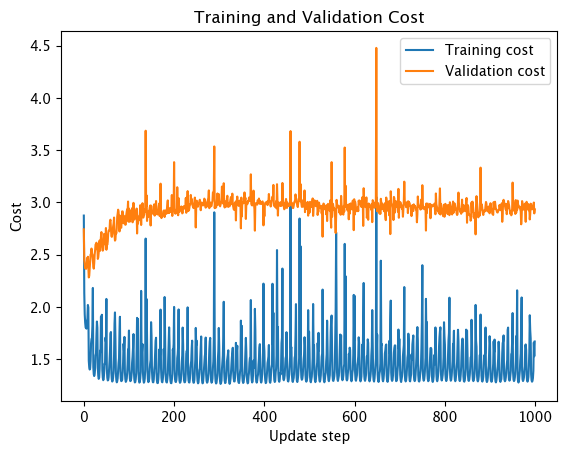

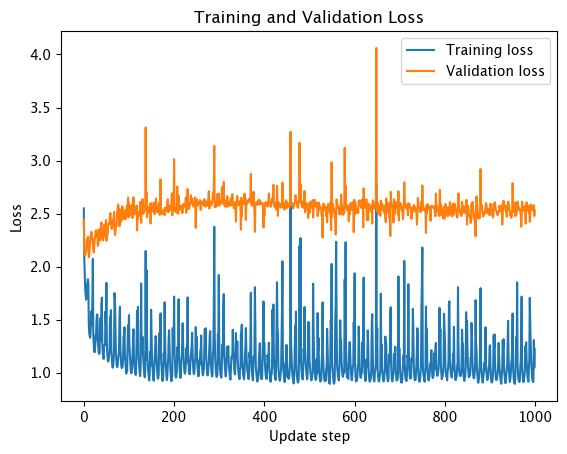

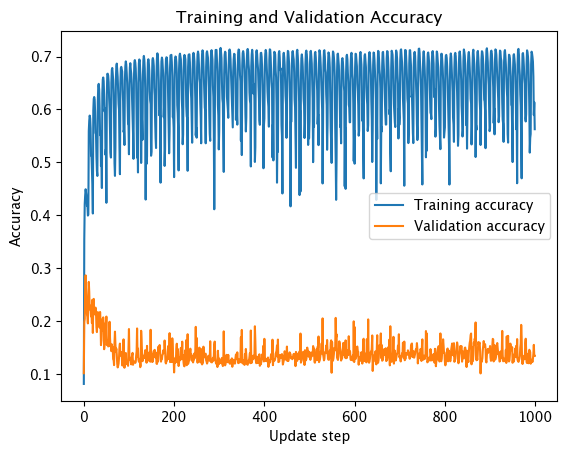

In [262]:
# Assignment 2.3

def compute_accuracy(X, Y, W1, b1, W2, b2):
    P, _ = forward_pass(X, W1, b1, W2, b2)
    predictions = np.argmax(P, axis=0)
    ground_truth = np.argmax(Y, axis=0)
    accuracy = np.mean(predictions == ground_truth)
    return accuracy


def train_network_cyclical(X, Y, val_X, val_Y, W1, b1, W2, b2, lamda, n_epochs, n_batch, eta_min, eta_max, ns):
    n = X.shape[1]
    train_losses = []
    train_costs = []
    train_accuracies = []
    val_losses = []
    val_costs = []
    val_accuracies = []


    for epoch in range(n_epochs):
        for j in range(0, n, n_batch):
            X_batch = X[:, j:j + n_batch]
            Y_batch = Y[:, j:j + n_batch]

            t = (epoch * (n // n_batch)) + j // n_batch
            eta = eta_min + ((t % (2 * ns)) / ns) * (eta_max - eta_min)

            P,H  = forward_pass(X_batch, W1, b1, W2, b2)

            grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X_batch, Y_batch, H, P, W1, b1, W2, b2, lamda)

            W1 -= eta * grad_W1
            b1 -= eta * grad_b1
            W2 -= eta * grad_W2
            b2 -= eta * grad_b2

            if t % 100 == 0:


                train_loss = -np.sum(Y_batch * np.log(P)) / Y_batch.shape[1]
                train_losses.append(train_loss)
                P_val, _ = forward_pass(val_X, W1, b1, W2, b2)
                val_loss = -np.sum(val_Y * np.log(P_val)) / val_Y.shape[1]
                val_losses.append(val_loss)

                train_cost = compute_cost(X, Y, W1, b1, W2, b2, lamda)
                val_cost = compute_cost(val_X, val_Y, W1, b1, W2, b2, lamda)
                train_costs.append(train_cost)
                val_costs.append(val_cost)

                train_accuracy = compute_accuracy(X, Y, W1, b1, W2, b2)
                val_accuracy = compute_accuracy(val_X, val_Y, W1, b1, W2, b2)
                train_accuracies.append(train_accuracy)
                val_accuracies.append(val_accuracy)

    return W1, b1, W2, b2, train_losses, train_costs, train_accuracies, val_losses, val_costs, val_accuracies


eta_min = 1e-5
eta_max = 1e-1
ns = 500
lamda = 0.01
n_epochs = 2 * ns  # Define the number of epochs you want to train for
n_batch = 100  # Define the batch size

W1, b1, W2, b2 = initialize_network(d, m, K)
W1, b1, W2, b2, train_losses, train_costs, train_accuracies, val_losses, val_costs, val_accuracies = train_network_cyclical(train_X, train_Y, val_X, val_Y, W1, b1, W2, b2, lamda, n_epochs, n_batch, eta_min, eta_max, ns)

import matplotlib.pyplot as plt

# Plot training and validation cost
plt.figure()
plt.plot(train_costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.xlabel("Update step")
plt.ylabel("Cost")
plt.title("Training and Validation Cost")
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.xlabel("Update step")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()





In [265]:
import numpy as np

def preprocess_data(train_X, train_Y, validation_X, validation_Y):
    # Normalize the pixel values
    train_X = train_X / 255.0
    validation_X = validation_X / 255.0

    # One-hot encode the labels
    train_Y = np.eye(10)[train_Y].T
    validation_Y = np.eye(10)[validation_Y].T

    return train_X, train_Y, validation_X, validation_Y

def load_all_data(validation_size=5000):
    train_X = []
    train_Y = []
    for i in range(1, 6):
        file_name = f"data_batch_{i}"
        X_batch, Y_batch, _ = load(file_name)
        train_X.append(X_batch)
        train_Y.append(Y_batch)
    
    train_X = np.concatenate(train_X, axis=1)
    train_Y = np.concatenate(train_Y, axis=1)

    validation_X = train_X[:, :validation_size]
    validation_Y = train_Y[:, :validation_size]
    train_X = train_X[:, validation_size:]
    train_Y = train_Y[:, validation_size:]

    return train_X, train_Y, validation_X, validation_Y

def load_test_data():
    file_name = "test_batch"
    X, Y, _ = load(file_name)
    return X, Y






# Load all 5 training batches and validation set
train_X, train_Y, validation_X, validation_Y = load_all_data()

# Set training parameters
n_epochs = 6
n_batch = 100
eta_min = 1e-5
eta_max = 1e-1
n_s = 2 * np.floor(train_X.shape[1] / n_batch)
l_min = -5
l_max = -1
num_lambdas = 8

# Initialize the network
W1, b1, W2, b2 = initialize_network(d, m, K)

# Coarse search for lambda
lambdas = np.logspace(l_min, l_max, num_lambdas)
best_lambda = None
best_accuracy = 0

for lamda in lambdas:
    W1_temp, b1_temp, W2_temp, b2_temp, train_losses, train_costs, train_accuracies, val_losses, val_costs, val_accuracies = train_network_cyclical(train_X, train_Y, val_X, val_Y, W1, b1, W2, b2, lamda, n_epochs, n_batch, eta_min, eta_max, ns)
    accuracy = compute_accuracy(validation_X, validation_Y, W1_temp, b1_temp, W2_temp, b2_temp)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lamda

# Train the network using the best lambda
W1, b1, W2, b2, train_losses, train_costs, train_accuracies, val_losses, val_costs, val_accuracies = train_network_cyclical(train_X, train_Y, val_X, val_Y, W1, b1, W2, b2,  best_lambda, n_epochs, n_batch, eta_min, eta_max, n_s)

# Load test set
test_X, test_Y = load_test_data()

# Compute test set accuracy
test_accuracy = compute_accuracy(test_X, test_Y, W1, b1, W2, b2)
print("Test set accuracy: ", test_accuracy)


Test set accuracy:  0.3544
